# Titanic: Machine Learning from Disaster

# Introduction

Competition Description from Kaggle website:
    
"The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy."

Thanks to Marco Giuseppe de Pinto who provided a starting point for me to work from. The notebook structure and feature engineering is based on his kernel. 

Note: This notebook is a living document. 

# Import Modules

In [241]:
# Data analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model fitting and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import Data

In [242]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
combined = [train, test]

# EDA

Get basic information about the data. 

The following observations can be made:
- There are 891 observations of 12 features 
- Age and Cabin have missing values
- There are 2 float variables, 5 integer variables and 5 object type variables

In [243]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Take a look at a few observations. 

In [244]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [245]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


View summary statistics of numeric variables. 

In [246]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The mean of Survived is 0.38 which means that approximately 38% of passengers survived. This can also be observed by checking the value counts of the variable. 

In [247]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

# Visual EDA

### Bar plots for categorical variables of interest

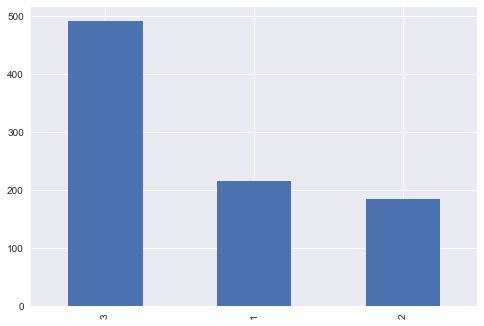

In [248]:
# Passenger Class
train.Pclass.value_counts().plot(kind='bar')
plt.show()

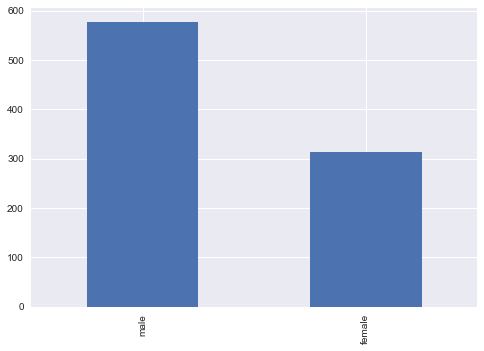

In [249]:
# Gender
train.Sex.value_counts().plot(kind='bar')
plt.show()

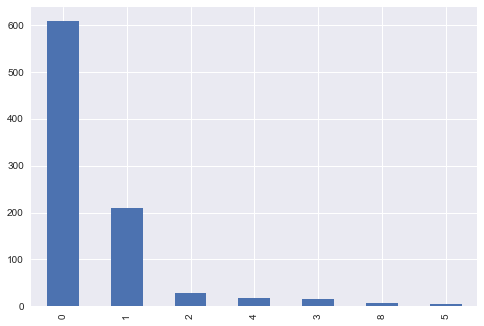

In [250]:
# Number of siblings
train.SibSp.value_counts().plot(kind='bar')
plt.show()

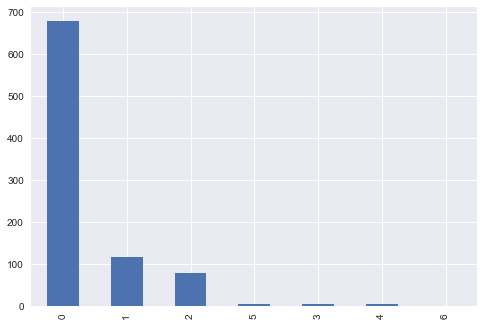

In [251]:
# Number of parents/children aboard
train.Parch.value_counts().plot(kind='bar')
plt.show()

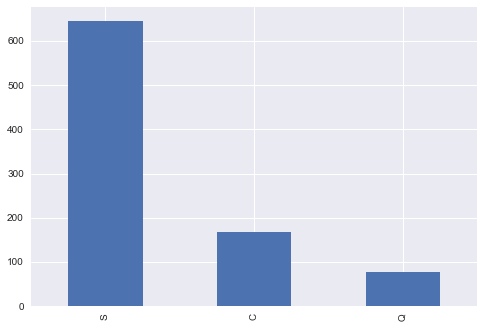

In [252]:
# Port of embarkation
train.Embarked.value_counts().plot(kind='bar')
plt.show()

### Histograms for numerical variables of interest

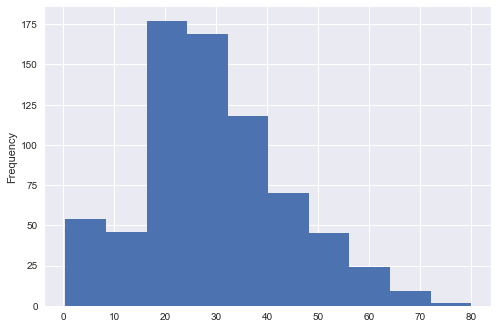

In [253]:
# Passenger Age
train.Age.plot(kind='hist')
plt.show()

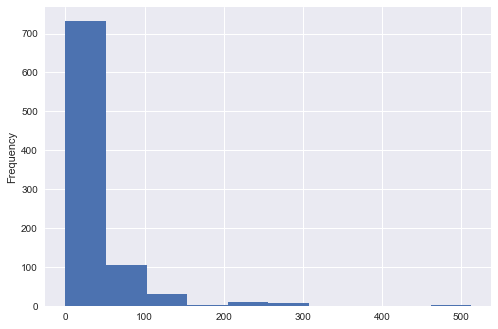

In [254]:
# Fare
train.Fare.plot(kind='hist')
plt.show()

### Correlation analysis

Before doing correlation analysis the categorical variables will be encoded numerically and scaled (this will be needed during the modeling stage in any case). 

In [255]:
# Encode Gender
for data in combined:
    data.Sex.unique()
    data.Sex = data.Sex.astype('category')
    data.Sex = data.Sex.cat.reorder_categories(['male', 'female'])
    data.Sex = data.Sex.cat.codes

In [256]:
# Encode Cabin
test_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']
train_categories = test_categories + ['T']
categories = [train_categories, test_categories]
for index, data in enumerate(combined):
    data.Cabin.unique()
    data.Cabin.value_counts(dropna=False).head()
    data.Cabin.fillna('U', inplace=True) # Replace missing values with 'U' (for Unknown)
    data.Cabin = data.Cabin.apply(lambda x: x[0])
    data.Cabin.unique()
    data.Cabin = data.Cabin.astype('category')
    data.Cabin = data.Cabin.cat.reorder_categories(categories[index])
    data.Cabin = data.Cabin.cat.codes
    data.Cabin = StandardScaler().fit_transform(data.Cabin.values.reshape(-1, 1))

In [257]:
# Encode Embarked
test_categories = ['S', 'C', 'Q']
train_categories = test_categories + ['U']
categories = [train_categories, test_categories]
for index, data in enumerate(combined):
    data.Embarked.unique()
    data.Embarked.fillna('U', inplace=True) # Replace missing values with 'U' (for Unknown)
    data.Embarked.unique()
    data.Embarked = data.Embarked.astype('category')
    data.Embarked = data.Embarked.cat.reorder_categories(categories[index])
    data.Embarked = data.Embarked.cat.codes
    data.Embarked = StandardScaler().fit_transform(data.Embarked.values.reshape(-1, 1))

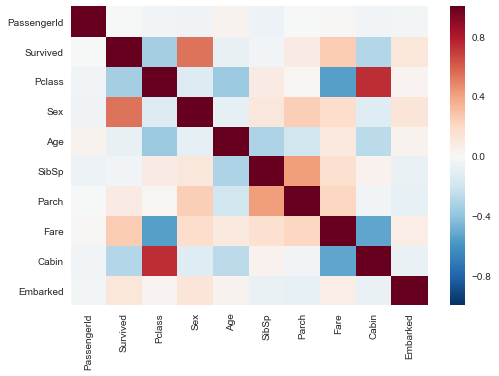

In [258]:
# Create heatmap
sns.heatmap(train.corr())
plt.show()

From the correlation plot we observe that the response variable Survived is positively correlated with Sex (Females more likely to survive) and Fare (higher Fare more likely to survive) and negatively correlated with PClass (1st class more likely to survive) and Cabin.

Other correlations are also intuitive, for example SibSp and Parch are positively correlated which suggests that if someone travelled with their siblings they probably also traveled with their parents. 

# Missing values

Check for missing values:

In [259]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [260]:
test.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin          False
Embarked       False
dtype: bool

Perform median imputation:

In [261]:
for data in combined:
    data['Age'] = data['Age'].fillna(data['Age'].median())

test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [262]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [263]:
test.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

# Feature Engineering

## New Features

Family size related features:

In [264]:
for data in combined:
    # Size of the family including the passenger
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
    
    # Introducing other features based on the family size
    data['Singleton'] = data['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    data['SmallFamily'] = data['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    data['LargeFamily'] = data['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

Replacing names with titles (e.g. Mr, Mrs): 

In [265]:
# Titles with very low frequencies to be put in a "Rare title" category
rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

# Mapping from title to number
replacement = {
    'Master': 0,
    'Miss': 1,
    'Mr': 2,
    'Mrs': 3,
    'Rare title': 4
}

# Perform replacement
for data in combined:
    data["Name"].replace(to_replace='(.*, )|(\\..*)', value='', inplace=True, regex=True)

    data.replace(rare_titles, "Rare title", inplace=True)

    data.replace(["Mlle","Ms", "Mme"], ["Miss", "Miss", "Mrs"], inplace=True)

    # Show title counts by sex
    print(data.groupby(["Sex", "Name"]).size().unstack(fill_value=0))

    # Now can numerically encode the titles
    data['Name'] = data['Name'].apply(lambda x: replacement.get(x))
    data['Name'] = StandardScaler().fit_transform(data['Name'].values.reshape(-1, 1))
    print(data.head()['Name'])

Name  Master  Miss   Mr  Mrs  Rare title
Sex                                     
0         40     0  517    0          20
1          0   185    0  126           3
0    0.132454
1    1.401453
2   -1.136545
3    1.401453
4    0.132454
Name: Name, dtype: float64
Name  Master  Miss   Mr  Mrs  Rare title
Sex                                     
0         21     0  240    0           5
1          0    79    0   72           1
0    0.113169
1    1.391672
2    0.113169
3    0.113169
4    1.391672
Name: Name, dtype: float64


# Final Preparation

Separate features and target (and drop irrelevant features e.g. PassengerID):

In [267]:
train_df = train.drop(['Ticket', 'PassengerId'], axis=1)
train_df.shape

(891, 14)

In [268]:
test_df = test.drop(['Ticket'], axis=1)
test_df.shape

(418, 14)

In [269]:
# Training and validation data
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]

# Testing data
X_test  = test_df.drop("PassengerId", axis=1).copy()

# Check shapes
X.shape, y.shape, X_test.shape

((891, 13), (891L,), (418, 13))

Quick check:

In [270]:
X.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,Singleton,SmallFamily,LargeFamily
0,3,0.132454,0,22.0,1,0,7.2500,0.511293,-0.568764,2,0,1,0
1,1,1.401453,1,38.0,1,0,71.2833,-1.914491,0.976263,2,0,1,0
2,3,-1.136545,1,26.0,0,0,7.9250,0.511293,-0.568764,1,1,0,0
3,1,1.401453,1,35.0,1,0,53.1000,-1.914491,-0.568764,2,0,1,0
4,3,0.132454,0,35.0,0,0,8.0500,0.511293,-0.568764,1,1,0,0


In [271]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [272]:
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,Singleton,SmallFamily,LargeFamily
0,3,0.113169,0,34.5,0,0,7.8292,0.500456,2.243165,1,1,0,0
1,3,1.391672,1,47.0,1,0,7.0000,0.500456,-0.677841,2,0,1,0
2,2,0.113169,0,62.0,0,0,9.6875,0.500456,2.243165,1,1,0,0
3,3,0.113169,0,27.0,0,0,8.6625,0.500456,-0.677841,1,1,0,0
4,3,1.391672,1,22.0,1,1,12.2875,0.500456,-0.677841,3,0,1,0


# Modeling

## Logistic Regression

In [273]:
log_reg = GridSearchCV(estimator = LogisticRegression(random_state=786),
                       param_grid = {'penalty': ['l1', 'l2'], 
                                     'C': np.linspace(0.6,1,10),
                                     'class_weight': [None, 'balanced']},
                       cv = 2,
                       refit = True)
log_reg.fit(X, y)
print(log_reg.best_params_)
Y_pred = log_reg.predict(X_test)
log_reg_acc_train = round(log_reg.score(X, y) * 100, 2)
log_reg_acc_val = round(log_reg.best_score_ * 100, 2)
print("Training accuracy: ", log_reg_acc_train)
print("Validation accuracy: ", log_reg_acc_val)

{'penalty': 'l1', 'C': 0.95555555555555549, 'class_weight': None}
('Training accuracy: ', 81.71)
('Validation accuracy: ', 80.13)


## Random Forest

In [274]:
random_forest = GridSearchCV(estimator = RandomForestClassifier(random_state=786),
                       param_grid = {'n_estimators': [100], 
                                     'max_features': np.linspace(0.3, 1, 10),
                                     'min_samples_leaf': list(range(1, 17, 3)), 
                                     'class_weight': [None, 'balanced']},
                       cv = 2,
                       refit = True)
random_forest.fit(X, y)
print(random_forest.best_params_)
Y_pred = random_forest.predict(X_test)
random_forest_acc_train = round(random_forest.score(X, y) * 100, 2)
random_forest_acc_val = round(random_forest.best_score_ * 100, 2)
print("Training accuracy: ", random_forest_acc_train)
print("Validation accuracy: ", random_forest_acc_val)

{'max_features': 0.92222222222222228, 'n_estimators': 100, 'min_samples_leaf': 7, 'class_weight': None}
('Training accuracy: ', 87.77)
('Validation accuracy: ', 81.82)


## Random forest after feature selection

In [275]:
relative_importances = pd.DataFrame(index=X.columns, 
                                    data=random_forest.best_estimator_.feature_importances_,
                                    columns=["importance"])

# Sort values to learn most important features
print(relative_importances.sort_values(by="importance", ascending=False))

# select only features with relative importance higher than 1%
selected_features = relative_importances[relative_importances.importance>0.01]

# create a list from those features: done
selected_list = selected_features.index

# transform both features_train and features_test components to include only selected features
features_train_selected = X[selected_list]
features_test_selected = X_test[selected_list]

random_forest_sel = GridSearchCV(estimator = RandomForestClassifier(random_state=786),
                       param_grid = {'n_estimators': [100, 200], 
                                     'max_features': np.linspace(0.3, 1, 8),
                                     'min_samples_leaf': list(range(1, 15, 2)), 
                                     'class_weight': [None, 'balanced']},
                       cv = 2,
                       refit = True)
random_forest_sel.fit(features_train_selected, y)
print(random_forest_sel.best_params_)
Y_pred = random_forest_sel.predict(features_test_selected)
random_forest_sel_acc_train = round(random_forest_sel.score(features_train_selected, y) * 100, 2)
random_forest_sel_acc_val = round(random_forest_sel.best_score_ * 100, 2)
print("Training accuracy: ", random_forest_sel_acc_train)
print("Validation accuracy: ", random_forest_sel_acc_val)

             importance
Sex            0.434777
Fare           0.128273
Pclass         0.117515
Age            0.103663
Name           0.057465
Cabin          0.055936
FamilySize     0.024261
Embarked       0.022090
SibSp          0.019131
LargeFamily    0.016649
SmallFamily    0.012253
Parch          0.005828
Singleton      0.002157
{'max_features': 0.5, 'n_estimators': 100, 'min_samples_leaf': 3, 'class_weight': 'balanced'}
('Training accuracy: ', 90.68)
('Validation accuracy: ', 81.82)


# Model Ranking

In [276]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Random Forest after Feature Selection'],
    'Training_Score': [log_reg_acc_train, random_forest_acc_train, random_forest_sel_acc_train], 
    'Validation_Score': [log_reg_acc_val, random_forest_acc_val, random_forest_sel_acc_val]})
models.sort_values(by='Validation_Score', ascending=False)

,Model,Training_Score,Validation_Score
1,Random Forest,87.77,81.82
2,Random Forest after Feature Selection,90.68,81.82
0,Logistic Regression,81.71,80.13


# Prepare Submission File

In [277]:
subm = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
subm.to_csv('subm.csv', index=False)